# Data Exploration

## Humidity and Temperature Readings from Residencial Sensors

In [1]:
import pandas as pd
import datetime
import string
import numpy as np
import matplotlib.pyplot as plt
import plotly

from scripts.data import deutsches_wetter_dienst, braunschweig
from scripts.plot import plotly_dwd
from scripts.plot import plotly_home

## Load Home Sensor Observations

This data contains humidity (in percentage) and temperature (in degrees Celsius). The data was collected using four S300 TH devices inside a residence in Braunschweig, Germany during the years 2013-2017. 

There are 4 sensors, positioned in different locations:  outside on the balcony, kitchen, bathroom, and living room. 

The 4 sensors are labeled: Temp1...Temp4, and Humi1...Humi4.

In [2]:
# read column headings
home = braunschweig('/Users/stewarta/Documents/DATA/htsensor/raw.data')
home.head(10)

,Temp1,Temp2,Temp3,Temp4,Temp8,Humi1,Humi2,Humi3,Humi4
datetime,,,,,,,,,
2013-04-14 07:44:23,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:44:30,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:45:37,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:46:03,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:46:19,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:47:19,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:47:26,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:50:14,10.2,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:50:22,10.2,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0


## Resampling the Data

Notice that sometimes there are multiple readings per second. Lets resample the data to make the frequency for each
reading equal to 1 calendar day (abbreviated as D). 


More Resampling Abbreviations: 

http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects


The  ffill() function tells us to replace null if they occur as a result of the resampling by copying the non-null value that occurred before the null In this case the nearest value is used. Other predefined fill methods are: 


More Functions to Handle Resampling Nulls:

https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html#upsampling

In [3]:
frequency = 'D'
home = home.resample(frequency).mean().ffill()
home.head()

,Temp1,Temp2,Temp3,Temp4,Temp8,Humi1,Humi2,Humi3,Humi4
datetime,,,,,,,,,
2013-04-14,15.696051,19.860450,23.692588,20.733840,16.897813,70.401580,47.047995,37.205954,44.666464
2013-04-15,17.653432,20.365598,21.085450,21.015988,16.734402,65.504316,50.438142,47.623510,47.817509
2013-04-16,16.500497,20.450207,20.310927,21.164996,15.867508,66.577815,50.214404,50.812500,48.237365
2013-04-17,16.010161,20.236791,19.731583,20.912616,15.809272,64.488569,49.231160,50.230737,47.296359
2013-04-18,17.064194,20.245818,20.180305,21.182530,15.878121,53.960445,44.769674,44.257520,43.027606


## Home Sensor Visual Inspection

Not all sensors are in operation throughout the period, so data is missing.

Also, in 2017, the residents moved to a new flat.  A visual inspection of the data reveals that the outside sensor, Temp1, became an inside sensor when the apartment changed. Can you detect when this happened?

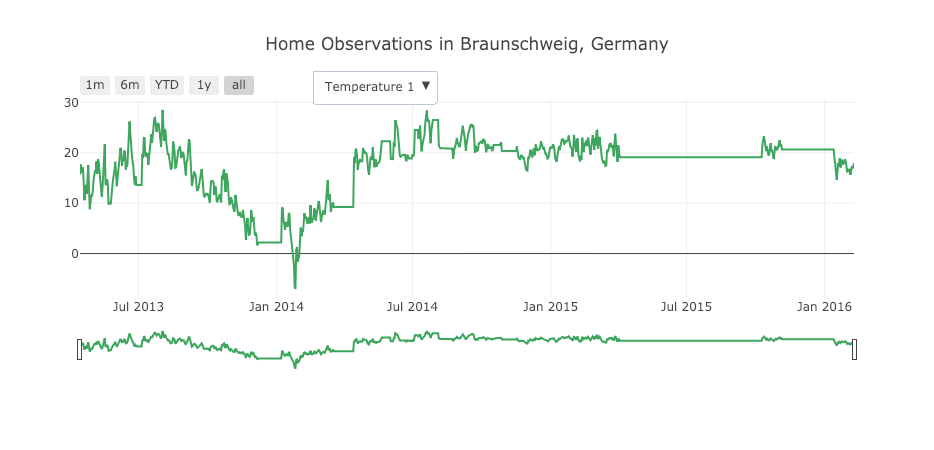

In [4]:
plotly.offline.init_notebook_mode(connected=True)
fig = plotly_home(home)
plotly.offline.iplot(fig)

## Load Official Weather Data Observations

Home readings are fun, but might be problematic for further analysis. 

Lets compare the home readings with an official data source.

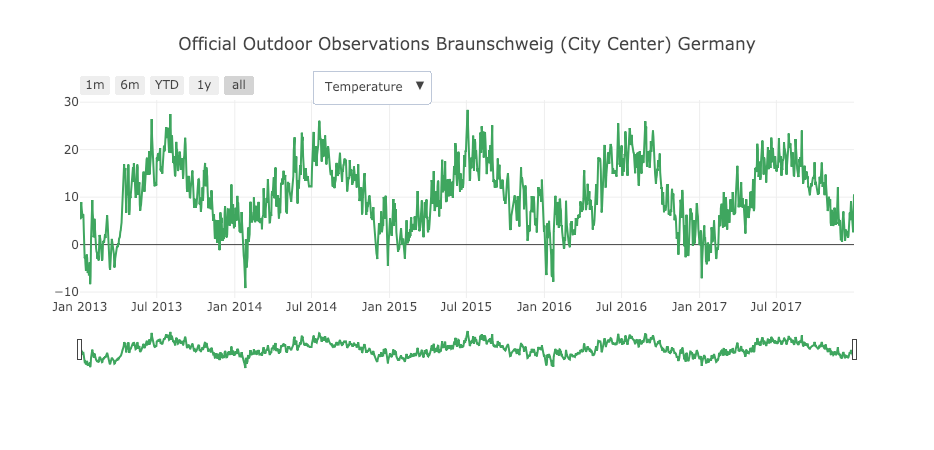

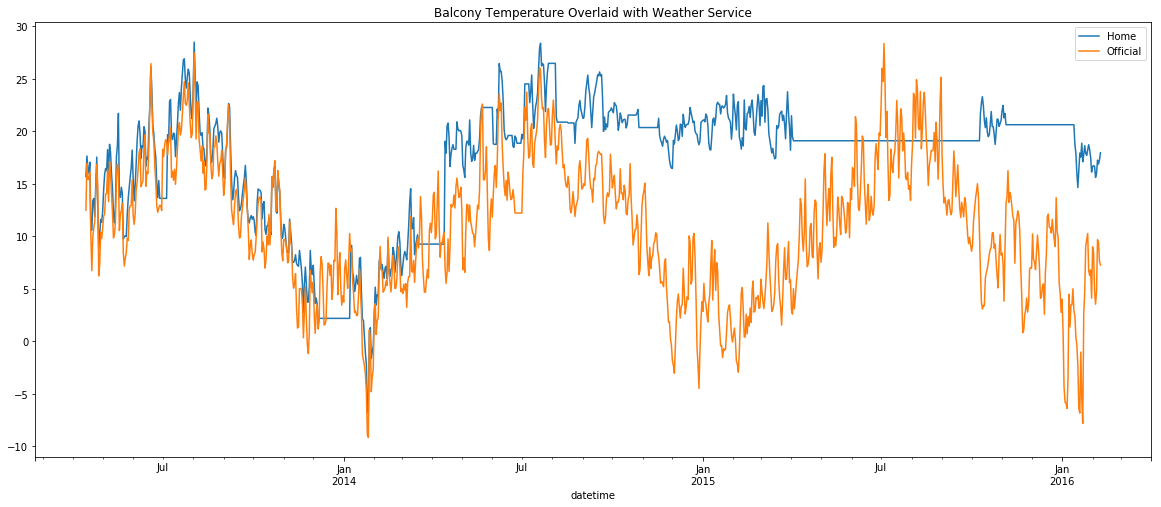

In [7]:
df = deutsches_wetter_dienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')

# resample
frequency = 'D'
df = df.resample(frequency).mean().ffill()

# join the data sets
joined = df.join(home)
joined.dropna(inplace=True)    

# plot
joined.loc[:,['Temp1','Temp']].rename(columns={'Temp': "Official",'Temp1': "Home"}).plot(figsize=(20,8), title='Balcony Temperature Overlaid with Weather Service')
plotly.offline.init_notebook_mode(connected=True)
fig = plotly_dwd(df)
plotly.offline.iplot(fig)

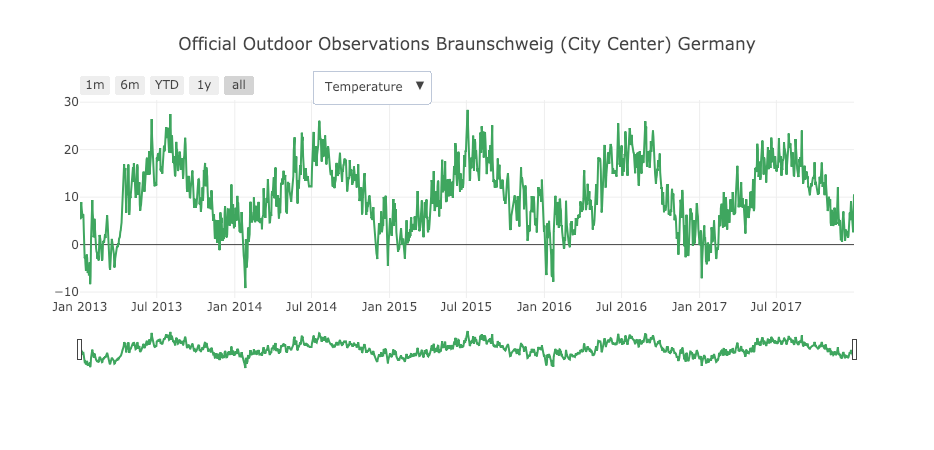

## Locate Outlier

In [81]:
# determine date of the outlier
df.loc[df['D_Temp'] < -10]

,D_Temp,D_Humi
datetime,,
2014-03-10,-44.277778,-4.444444


## Locate Missing Value

In [82]:
df.loc[pd.isnull(df[['D_Temp']]).any(1)]

,D_Temp,D_Humi
datetime,,
2014-03-09,NaN,NaN


## Manually Correct Errors for Two Days 
Only two values so, manually correct using online lookup 
https://latin.wunderground.com/history/airport/EDVE/2018/4/2/DailyHistory.html

In [83]:
df.loc['2014-03-09':'2014-03-10','D_Temp'] = [10,10]
df.loc['2014-03-09':'2014-03-10','D_Humi'] = [57,52]
df.loc['2014-03-09':'2014-03-10',['D_Temp', 'D_Humi']] 

,D_Temp,D_Humi
datetime,,
2014-03-09,10.0,57.0
2014-03-10,10.0,52.0


In [ ]:
## Decompose Series

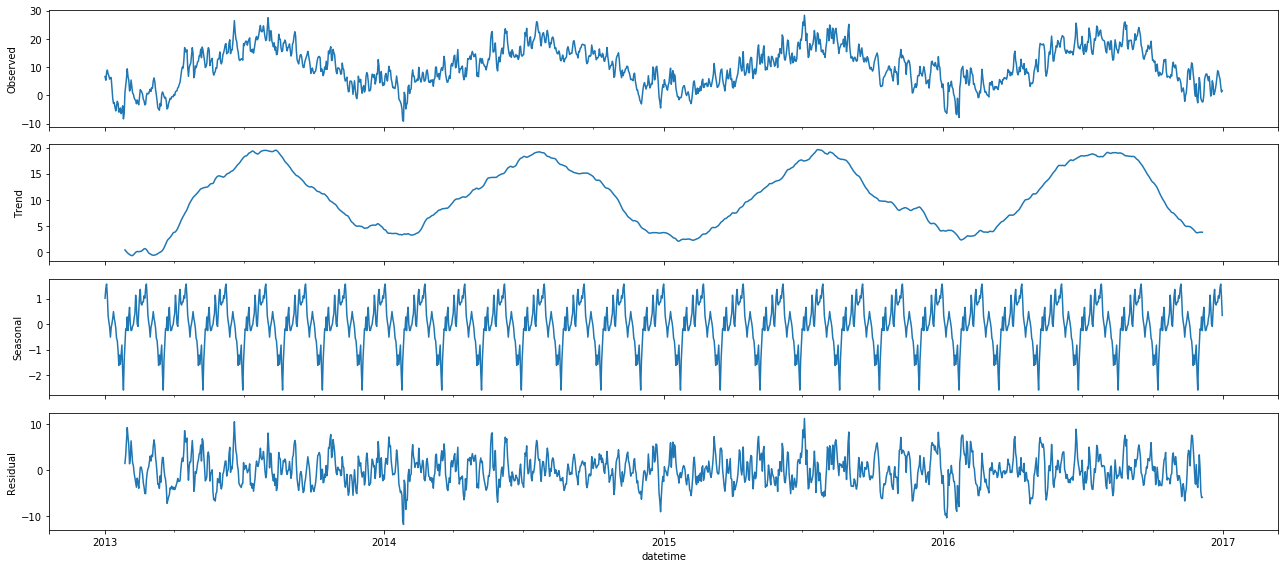

In [84]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['D_Temp'], freq=52 , model='additive')
fig = decomposition.plot()
plt.show()

## Inside Data: Visual Inspection
### Q: Which Sensor do you think was located outside in 2013?

In [96]:
col = 'Temp1'

dates = home.index.values
source = ColumnDataSource(data=dict(date=dates, close=home[col]))

p = figure(title="Home Temperature Observations Braunschweig (City Center) Germany (2013 - 2016)",
           plot_height=300, plot_width=800, tools="", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[0], dates[home[col].shape[0]-1]))

p.line('date', 'close', source=source)
p.yaxis.axis_label = 'Celcius'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))

## Interpolate the missing values 

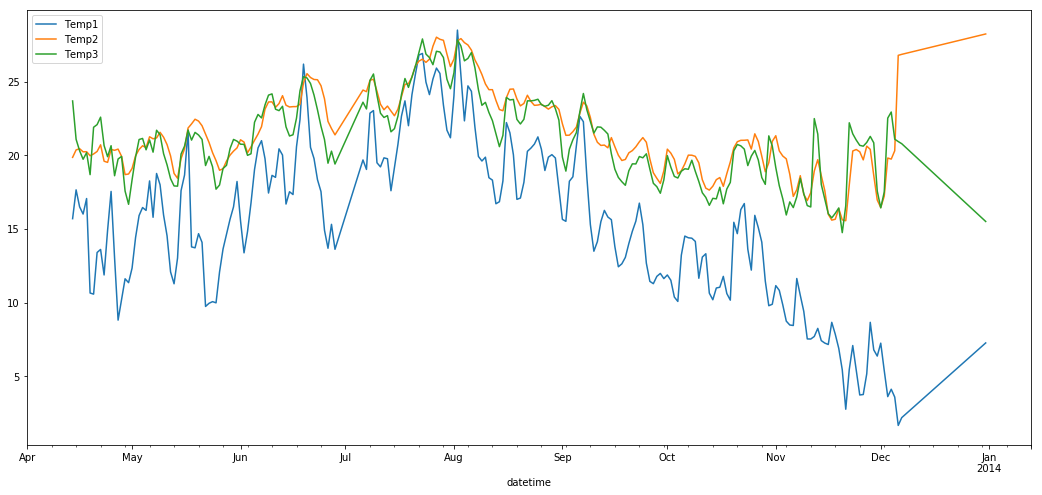

In [43]:
int_home = df.interpolate()
int_home.loc[df.index.year==2013,['Temp1','Temp2','Temp3']].plot()

In [53]:
rcParams['figure.figsize'] = 18, 8

home = int_home.loc[int_home.index.year==2013,['Temp3']]
decomposition = sm.tsa.seasonal_decompose(home, freq=12 , model='additive')
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values

## Conclusion:

Pretty Cool:  temparture reading collected with devices in my home overlay quite nicely with the official data from German Wetterdeinst (DWD). Since my data has missing values due to relocation and downtime we can use DWD to interpolate missing values in my own data set.

In [95]:
# overlay a sample of the Germany weather data with the home reading.

filter = (df.index.year == 2013) & (df.index.month == 4)
x = np.array(df[filter].index)
y = np.array(df[filter]['Temp1'])
y1 = np.array(df[filter]['D_Temp'])
fig, ax = plt.subplots()
ax.set_title('Overlay Germany Weather Data April, 2013')
ax.plot(x, y, 'black', label = 'home sensor')
ax.plot(x, y1, '.', label='weather svc.', color = 'red')
fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Celcius')
ax.legend(loc='best')

KeyError: 'Temp1'